In [1]:
%config Completer.use_jedi = False

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

In [3]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [4]:
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

n_campaigns = 400

def lta_df(df):
    df0 = df
    df1 = add_derived_columns(df0)
    df2 = sample_campaigns(df1, n_campaigns)
    df3 = filter_journeys_by_length(df2, 2)
    df4 = balance_conversions(df3)
    df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
    df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])
    return df6
df6 = lta_df(df0)
print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

699088
[351253, 347835]


<html><font color = 'blue' size = 4 > Last Touch Attribute
    

In [5]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)


In [54]:
lta_1 = pd.DataFrame(lta, columns = ['Value'])
lta_1.head()
lta_1.to_csv('lta.csv')

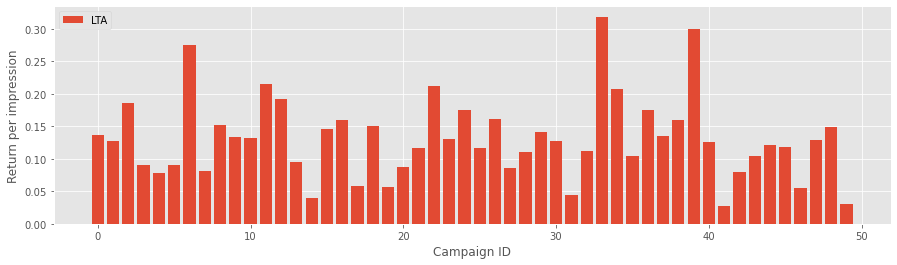

In [6]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4 > First Touch Attribute

In [7]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

In [53]:
fta_1 = pd.DataFrame(fta, columns = ['Value'])
fta_1.head()
fta_1.to_csv('fta.csv')

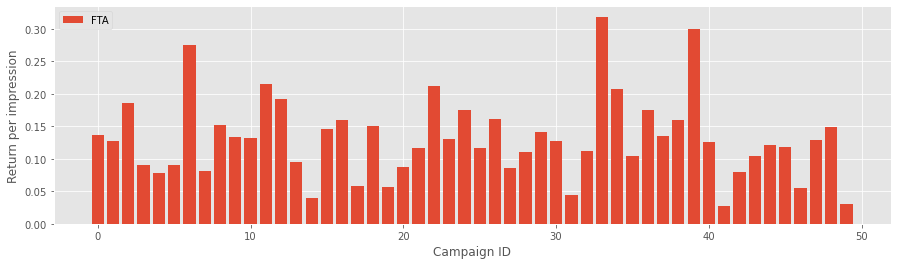

In [9]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4 > Linear Model

In [34]:
def linear_model(df):
    df = df6
    # Filter the data frame of uid which has conversion ==1 
    df_conv = df6.copy()
    # Creating a dataframe conatinng the total count of each campaigin in a particualr jid
    df_count = df_conv.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    # groupby jid and campaign to merge with count data frame later
    df_t = df_conv.groupby(['jid', 'campaign']).size().reset_index(name='Freq')#.sort_values(by = 'jid')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['linear_weights'] = 1/df_merge['count']
    # creating a final data frame consisting of weights from individual campaigns 
    linear_df = df_merge.groupby('campaign')['linear_weights'].agg('sum').reset_index(name = 'weight')
    totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
    linear_df = pd.merge(totalCampaign, linear_df)
    linear_model = np.array(linear_df['weight']/linear_df['count'])
    return linear_model

In [35]:
lm = linear_model(df6)

In [52]:
lm_1 = pd.DataFrame(lm, columns = ['Value'] )
lm_1.to_csv('lm.csv')

In [40]:
lm

array([0.22619048, 0.28054207, 0.27368307, 0.257011  , 0.26544289,
       0.17902734, 0.20736448, 0.2470794 , 0.26830823, 0.13769231,
       0.31878307, 0.27402402, 0.18554067, 0.18410189, 0.20004984,
       0.22473404, 0.25626667, 0.1010101 , 0.16666667, 0.34161793,
       0.27064394, 0.28992674, 0.17616494, 0.26725572, 0.30392157,
       0.26014263, 0.31777778, 0.19626112, 0.181143  , 0.22853009,
       0.21269683, 0.17704707, 0.37431319, 0.35173042, 0.30439815,
       0.24287343, 0.2979798 , 0.26523995, 0.21849266, 0.32511211,
       0.19028871, 0.24012508, 0.29733456, 0.26829268, 0.32352941,
       0.1214378 , 0.33790323, 0.17969272, 0.20979131, 0.25070922,
       0.30708333, 0.3030303 , 0.18045491, 0.31333333, 0.23515109,
       0.17132725, 0.24984472, 0.19187726, 0.27012911, 0.18448276,
       0.14299587, 0.24269739, 0.22932032, 0.2254835 , 0.23070175,
       0.20943689, 0.24758513, 0.23668057, 0.36582902, 0.16045205,
       0.15273742, 0.21941581, 0.22116487, 0.25260417, 0.13177

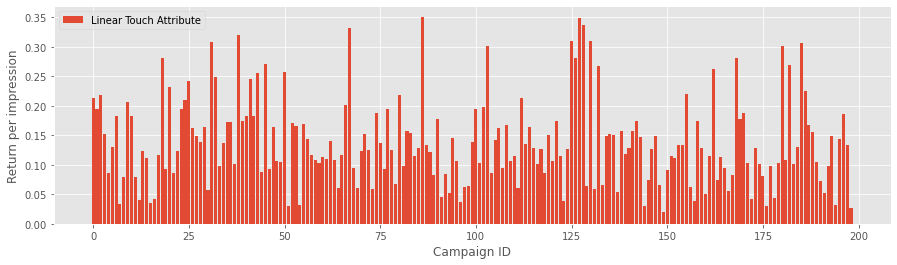

In [12]:
campaign_idx = range(1, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lm[campaign_idx])), lm[campaign_idx], label='Linear Model' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4 > U Shape Attribute Model

In [30]:
def uShapeAttri(df):
    df6 = df
    df_conv = df6.copy()
    idx1 = df_conv.groupby(['jid'])['timestamp_norm'].transform(min)
    idx2 = df_conv.groupby(['jid'])['timestamp_norm'].transform(max) 
    df1 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
    df2 = df_conv[df_conv['timestamp_norm'].isin(idx2)]
    df1 = pd.concat([df1,df2])
    df1['weight'] = .20
    df1 = df1[['jid', 'campaign', 'weight']]
    ### Creating a data frame for the middle camapigns in each jid 
    df2 = df_conv[~df['timestamp_norm'].isin(idx2)]
    df_count = df2.groupby('jid')['campaign'].nunique().reset_index(name = 'count')
    df_t = df2.groupby(['jid', 'campaign']).size().reset_index(name='Freq')
    df_merge = pd.merge(df_count,df_t)
    # Identifying each indivudal campaign weights
    df_merge['weight'] = 0.6/df_merge['count']
    df_merge = df_merge[['jid', 'campaign','weight']]
    # Concating the dataframe for both First and Last touch points weights with the middle weight 
    df = pd.concat([df1,df_merge]) 
    return df

uDf = uShapeAttri(df6)
uDf = uDf.groupby('campaign')['weight'].agg('sum').reset_index(name = 'weight')
# Creating the total campaign data frame
totalCampaign = df6.groupby(['campaign'])['campaign'].count().reset_index(name = 'count')
uDf = pd.merge(totalCampaign, uDf)
# Creating final utouch model 
uTouchModel = np.array(uDf['weight']/uDf['count'])

In [51]:
ushape = pd.DataFrame(uTouchModel, columns = ['Value'])
ushape.to_csv('ushape.csv')

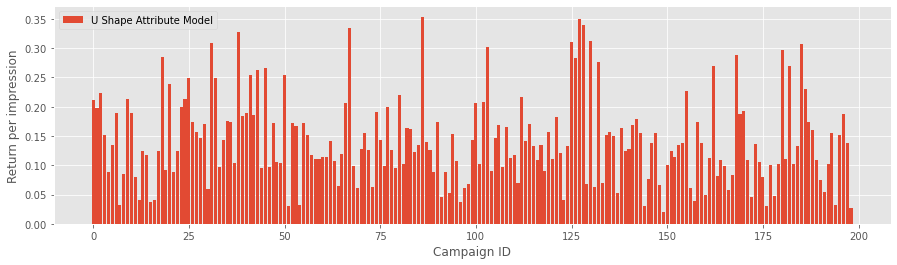

In [14]:
campaign_idx = range(1, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uTouchModel[campaign_idx])), uTouchModel[campaign_idx], label='U Shape Attribute Model' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4 > Time Decay Model

In [56]:
df6['days_time'] = df6['conversion_timestamp'] - df6['timestamp']
df6['days'] = (df6.days_time / 86400.).apply(int)

timedf = df6[['uid', 'campaign', 'conversion','conversion_id','click', 'timestamp_norm', 'jid','days']]

df_converted = timedf[timedf['conversion'] == 1]
df_converted['timedecay'] = df_converted['days'].transform(lambda x: 2**(-x/7))

tdf = df_converted.groupby('campaign')['timedecay'].agg('sum').reset_index(name = 'weight')

timedecay = pd.merge(totalCampaign, tdf, how = 'left')
timedecay.weight = timedecay.weight.fillna(0)
timedecay = np.array(timedecay['weight']/timedecay['count'])

<ipython-input-56-ce7cd7fb6626>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['timedecay'] = df_converted['days'].transform(lambda x: 2**(-x/7))


In [61]:
timedelta1 = pd.DataFrame(timedecay, columns = ['Value'])
timedelta1.to_csv('timedelta.csv')

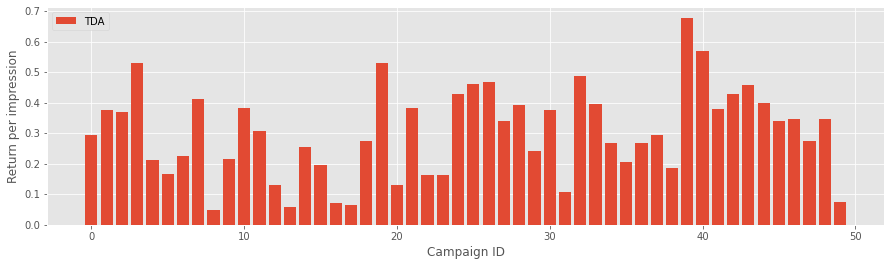

In [58]:
campaign_idx = range(0, 50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(timedecay[campaign_idx])), timedecay[campaign_idx], label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<html><font color = 'blue' size = 4 > ROI

In [17]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])
def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))


In [59]:
pitches = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, fta, uTouchModel, lm, timedecay]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(pitch, j, reward))

0.5 0 : 908
0.5 1 : 908
0.5 2 : 1133
0.5 3 : 1134
0.5 4 : 790
1.0 0 : 298
1.0 1 : 298
1.0 2 : 1075
1.0 3 : 1068
1.0 4 : 257
1.5 0 : 352
1.5 1 : 352
1.5 2 : 982
1.5 3 : 944
1.5 4 : 173
2.0 0 : 412
2.0 1 : 412
2.0 2 : 839
2.0 3 : 726
2.0 4 : 193
2.5 0 : 476
2.5 1 : 476
2.5 2 : 629
2.5 3 : 636
2.5 4 : 203
3.0 0 : 519
3.0 1 : 519
3.0 2 : 494
3.0 3 : 501
3.0 4 : 218
